# Download Dataset from Kaggle

In [ ]:
!pip install kaggle --quiet

from google.colab import drive
drive.mount('/content/drive')

!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d alsaniipe/cardatasets

!unzip cardatasets -d ./dataset_folder

Mounted at /content/drive
Dataset URL: https://www.kaggle.com/datasets/alsaniipe/cardatasets
License(s): apache-2.0
  0% 0.00/1.06M [00:00<?, ?B/s]
100% 1.06M/1.06M [00:00<00:00, 604MB/s]
Archive:  cardatasets.zip
  inflating: ./dataset_folder/dataset/Images/Test/audi/21.jpg  
  inflating: ./dataset_folder/dataset/Images/Test/audi/22.jpg  
  inflating: ./dataset_folder/dataset/Images/Test/audi/23.jpg  
  inflating: ./dataset_folder/dataset/Images/Test/audi/24.jpg  
  inflating: ./dataset_folder/dataset/Images/Test/audi/25.jpg  
  inflating: ./dataset_folder/dataset/Images/Test/audi/26.jpg  
  inflating: ./dataset_folder/dataset/Images/Test/audi/27.jpg  
  inflating: ./dataset_folder/dataset/Images/Test/audi/28.jpg  
  inflating: ./dataset_folder/dataset/Images/Test/audi/29.jpg  
  inflating: ./dataset_folder/dataset/Images/Test/lamborghini/1.jpg  
  inflating: ./dataset_folder/dataset/Images/Test/lamborghini/10.jpg  
  inflating: ./dataset_folder/dataset/Images/Test/lamborghini/11.jpg 

# Handle dataset

In [ ]:
import os
import shutil
from glob import glob

def move_rename_images(data_src, data_dst):
  if os.path.exists(data_src):
    # Looping for each class
    for class_dir in os.listdir(data_src):
      class_path = os.path.join(data_src, class_dir)

      if os.path.isdir(class_path):

        for i, img_path in enumerate(glob(class_path + "/*.*"), start=1):
          root, ext = os.path.splitext(img_path)
          new_name = f"{class_dir}_{i}{ext}"

          shutil.copy(img_path, os.path.join(data_dst, new_name))


# Current dir
src_root = "/content/dataset_folder/dataset/Images"

# New dataset root
dst_root = "/content/dataset"
train_dst = os.path.join(dst_root, "train")
test_dst = os.path.join(dst_root, "test")

os.makedirs(train_dst, exist_ok=True)
os.makedirs(test_dst, exist_ok=True)


move_rename_images(os.path.join(src_root, "Train"), train_dst)
move_rename_images(os.path.join(src_root, "Test"), test_dst)

# Install dependencies


In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms
from matplotlib import pyplot as plt
import numpy as np

# Hyperparameters

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.0002
noise_dim = 64
batch_size = 8
num_epochs = 10

# Create Discriminator
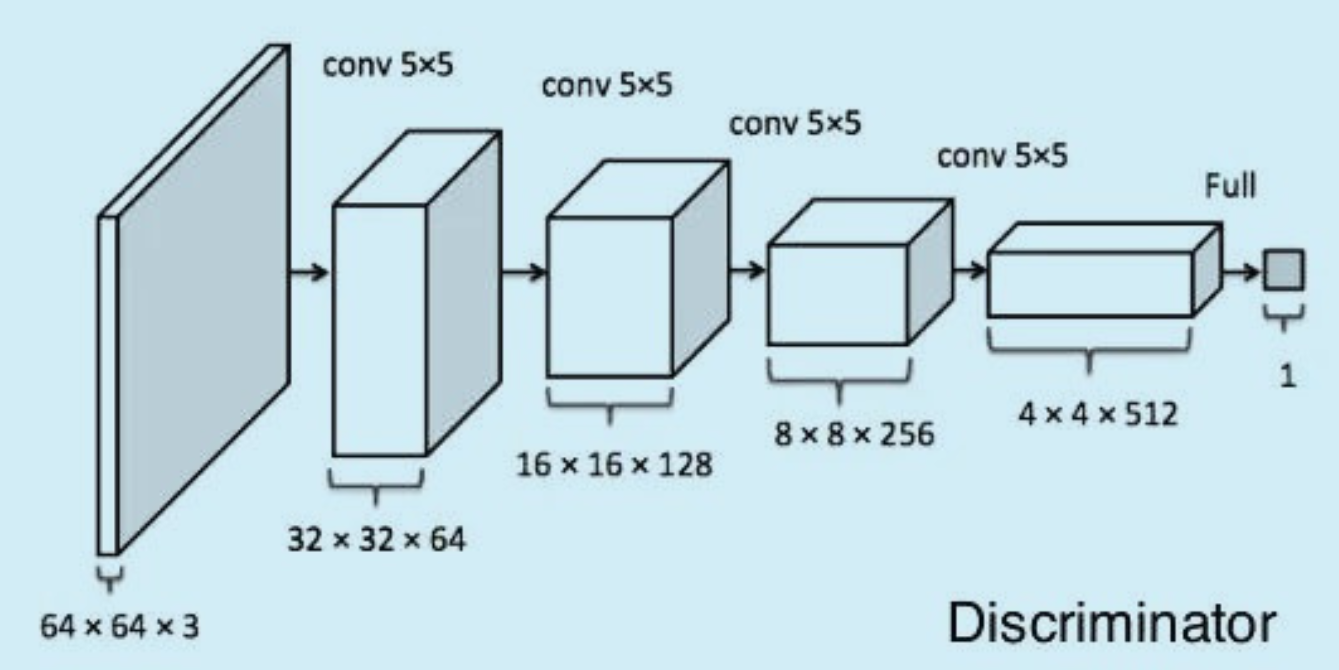

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, channels_img, features_disc):
    super(Discriminator, self).__init__()

    self.disc = nn.Sequential(
      # Input Image --> 64x64
      nn.Conv2d(channels_img, features_disc, kernel_size=4, stride=2, padding=1), # 32x32
      nn.LeakyReLU(0.2),
      self.conv_block_disc(features_disc, features_disc*2, 4, 2, 1),    # 16x16
      self.conv_block_disc(features_disc*2, features_disc*4, 4, 2, 1),  # 8x8
      self.conv_block_disc(features_disc*4, features_disc*8, 4, 2, 1),  # 4x4
      nn.Conv2d(features_disc*8, 1, 4, 2, 0),                           # 1x1
      nn.Sigmoid(),
    )

  def conv_block_disc(self, in_features, out_features, kernel_size, stride, padding):
    return nn.Sequential(
        nn.Conv2d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            bias=False,
        ),
        nn.BatchNorm2d(out_features),
        nn.LeakyReLU(0.2),
    )

  def forward(self, x):
    return self.disc(x)



# Create Generator
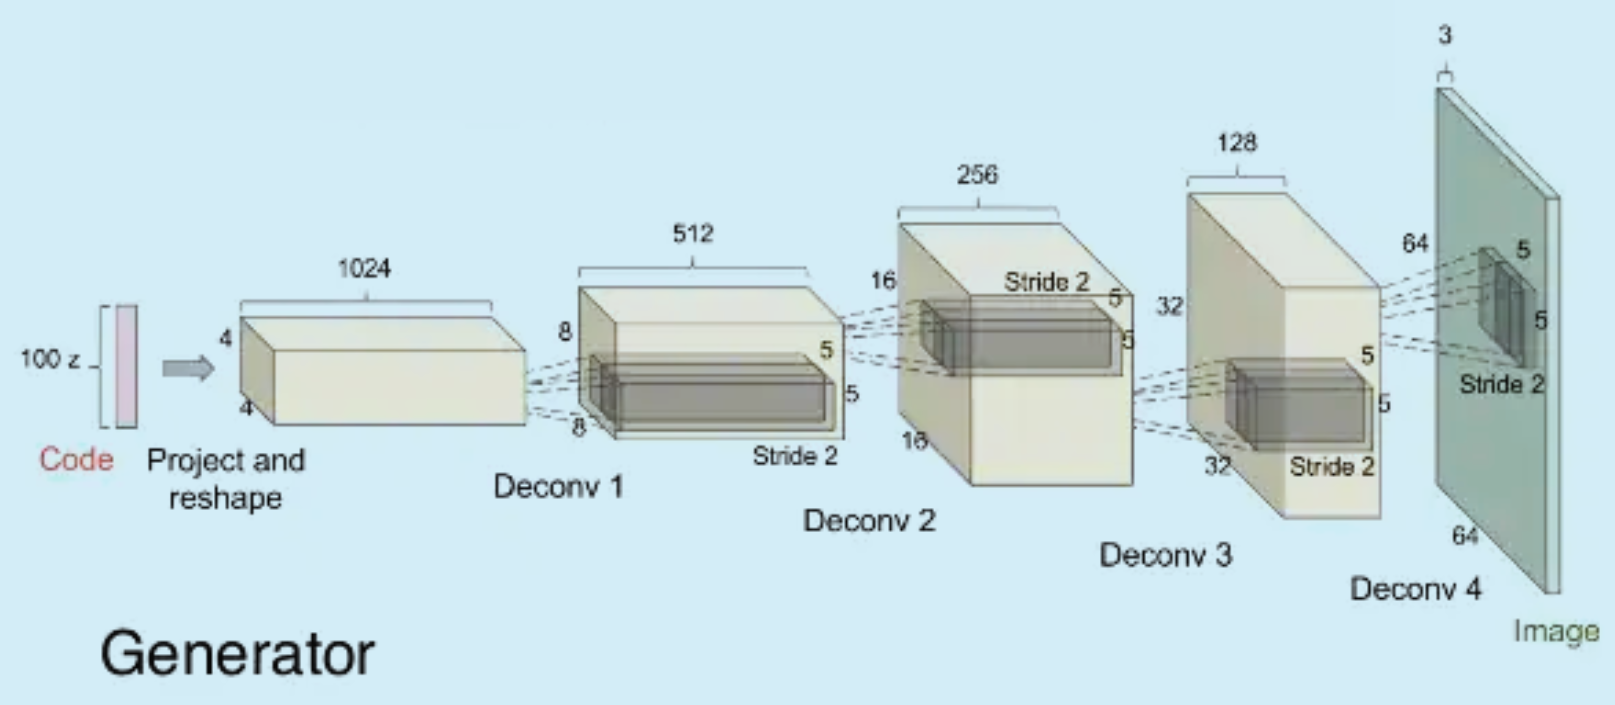

In [ ]:
class Generator(nn.Module):
  def __init__(self, noise_dim, channels_img, features_gen):
    super(Generator, self).__init__()

    self.gen = nn.Sequential(
        self.conv_block_gen(noise_dim, features_gen*8, 4, 1, 0),                # 64*16 = 1024
        self.conv_block_gen(features_gen*8, features_gen*4, 4, 2, 1),           # 64*8 = 512
        self.conv_block_gen(features_gen*4, features_gen*2, 4, 2, 1),           # 64*4 = 256
        self.conv_block_gen(features_gen*2, features_gen, 4, 2, 1),             # 64*2 = 128
        nn.ConvTranspose2d(features_gen, channels_img, 4, 2, 1, bias=False),    # 64*1 = 64
        nn.Tanh(),
    )

    # print(self.gen)

  def conv_block_gen(self, in_features, out_features, kernel_size, stride, padding):
    return nn.Sequential(
        nn.ConvTranspose2d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            bias=False,
        ),
        nn.BatchNorm2d(out_features),
        nn.ReLU(),
        )

  def forward(self, x):
    return self.gen(x)

In [ ]:
def init_weights(model):
  for m in model.modules():
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
      nn.init.normal_(m.weight.data, 0.0, 0.02)


# Check everything is alright

In [ ]:
def test():
  N, in_channels, H, W = 8, 3, 64, 64
  noise_dim = 100
  x = torch.randn((N, in_channels, H, W))
  disc = Discriminator(in_channels, 8)
  init_weights(disc)

  # print(disc(x).shape)
  assert disc(x).shape == (N, 1, 1, 1)

  gen = Generator(noise_dim, in_channels, 64)
  z = torch.randn((N, noise_dim, 1, 1))

  # print(gen(z).shape)
  assert gen(z).shape == (((N, in_channels, H, W)))

  print("Sucsses")

test()

Sucsses


# Creation Fixed Noise & Normalize Pixels

In [ ]:
features_dis = 64
features_gen = 64
channels_num = 3
image_size = 64

disc = Discriminator(channels_num, features_dis).to(device)
gen = Generator(noise_dim, channels_num, features_gen).to(device)

fixed_noise = torch.randn((batch_size, noise_dim, 1, 1)).to(device)

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.5 for _ in range(channels_num)], [0.5 for _ in range(channels_num)]
        )] # Modified normalization for 3 channels
)

# Handle Dataset

In [ ]:
dataset = datasets.ImageFolder(root="dataset", transform=transform)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Optimizer & Loss Function

In [ ]:
opt_disc = torch.optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))
opt_gen = torch.optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))
criterion = nn.BCELoss()

writer_fake = SummaryWriter(f"runs/GAN_Car/fake")
writer_real = SummaryWriter(f"runs/GAN_Car/real")
step = 0

In [ ]:
from os import write
for epoch in range(num_epochs):
  for batch_id, (real, _) in enumerate(loader):
    real = real.to(device)
    noise = torch.randn((batch_size, noise_dim, 1, 1)).to(device) # Ensure noise is 4D
    fake = gen(noise)

    ### Train Discriminator
    disc_real = disc(real).reshape(-1)
    lossD_real = criterion(disc_real, torch.ones_like(disc_real))

    disc_fake = disc(fake.detach()).view(-1)
    lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))

    lossD = (lossD_real + lossD_fake) / 2

    disc.zero_grad()
    lossD.backward(retain_graph=True)
    opt_disc.step()

    ### Train Generator
    output = disc(fake).view(-1)
    lossG = criterion(output, torch.ones_like(output))
    gen.zero_grad()
    lossG.backward()
    opt_gen.step()

    if batch_id == 0:
      print(f"Epoch [{epoch+1}/{num_epochs}] Batch {batch_id}/{len(loader)} \
            Loss D: {lossD:.4f}, loss G: {lossG:.4f}")

      with torch.no_grad():
        fake = gen(fixed_noise).reshape(-1, 1, image_size, image_size)
        data = real.reshape(-1, 1, image_size, image_size)
        img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
        img_grid_real = torchvision.utils.make_grid(data, normalize=True)

        writer_fake.add_image("Fake", img_grid_fake, global_step=step)
        writer_real.add_image("Real", img_grid_real, global_step=step)

        step += 1

Epoch [1/10] Batch 0/16             Loss D: 0.6813, loss G: 4.1503
Epoch [2/10] Batch 0/16             Loss D: 0.1845, loss G: 9.7369
Epoch [3/10] Batch 0/16             Loss D: 0.1408, loss G: 12.9056
Epoch [4/10] Batch 0/16             Loss D: 0.4045, loss G: 14.4570
Epoch [5/10] Batch 0/16             Loss D: 0.0202, loss G: 11.6400
Epoch [6/10] Batch 0/16             Loss D: 0.0561, loss G: 8.9959
Epoch [7/10] Batch 0/16             Loss D: 0.8301, loss G: 3.4154
Epoch [8/10] Batch 0/16             Loss D: 0.2135, loss G: 3.8003
Epoch [9/10] Batch 0/16             Loss D: 0.3144, loss G: 6.0206
Epoch [10/10] Batch 0/16             Loss D: 0.3184, loss G: 4.8728


In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir=runs/GAN_Car

Reusing TensorBoard on port 6006 (pid 1522), started 0:06:30 ago. (Use '!kill 1522' to kill it.)

<IPython.core.display.Javascript object>